In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

In [2]:
# creating and testing web search tool

import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, unquote
import time

from langchain.agents import Tool

cse_key = os.environ["GOOGLE_CSE_KEY"]
cse_id = os.environ["GOOGLE_CSE_ID"]

def web_search_and_ingest(query):
    # first search query via CSE

    #query = search_query.replace('+', ' ')

    cse_url = 'https://www.googleapis.com/customsearch/v1'
    cse_params = {
        'q': query,
        'key': cse_key,
        'cx': cse_id
    }
    
    response = requests.get(cse_url, cse_params)

    # obtain first k urls

    cse_results = response.json()

    target_url_set = set()
    
    if 'items' in cse_results:
        for result in cse_results['items']:
            if len(target_url_set) >= 5:    # number of search results (need to add macro)
                break
            else:
                #target_url_set.add(result['link'])
                print(result['link'])
    
    # scrape links

    # site_loader = AsyncHtmlLoader(list(target_url_set))
    # scraped_docs = site_loader.load()
    
    # text_trns = Html2TextTransformer()
    # text_docs = text_trns.transform_documents(scraped_docs)

    # # split and embed

    # splits = text_splitter.split_documents(text_docs)
    # vectorstore.add_documents(documents=splits)

In [3]:
web_search_tool = Tool(
    name="WebSearch",
    func=web_search_and_ingest,
    description="Use when current context is insufficient or up-to-date info is required."
)

In [4]:
tools = [web_search_tool]
web_search_tool.invoke("What is runescape?")

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


https://www.reddit.com/r/runescape/comments/181jfok/what_is_runescape/
https://runescape.com/
https://www.reddit.com/r/2007scape/comments/52o8ry/why_is_runescape_called_runescape/
https://en.wikipedia.org/wiki/RuneScape
https://www.reddit.com/r/runescape/comments/14z39c2/is_runescape_3_the_same_thing_as_runescape/
https://www.runescape.com/community
https://www.quora.com/I-want-to-start-playing-RuneScape-today-Which-is-better-old-or-new
https://www.facebook.com/groups/rs3community/posts/1794874511267704/
https://rs.runescape.com/membership
https://us.forums.blizzard.com/en/wow/t/how-is-runescape-almost-as-popular-as-wow/974362


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

In [5]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model("openai:gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

In [7]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")

## For now, will just search, embed, retrieve each time

In [8]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [9]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile(checkpointer=memory)

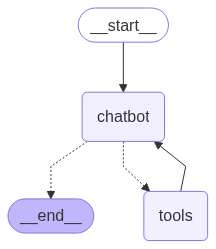

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config={"thread_id": 1}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  what is runescape?


Assistant: RuneScape is a massively multiplayer online role-playing game (MMORPG) created and published by Jagex. Initially released in January 2001, RuneScape is set in a fantasy world called Gielinor, which is divided into different kingdoms, regions, and cities. Players create and customize their characters, explore the world, complete quests, engage in combat, and interact with other players.

The game features a variety of activities including:

- **Quests**: Players can complete story-driven quests that offer rewards and experience.
- **Skills**: RuneScape has a wide range of skills that players can train, such as combat skills, gathering skills (like fishing and mining), and production skills (like crafting and cooking).
- **Combat**: Players can fight monsters and other players using various weapons and combat styles.
- **Economy**: There is a player-driven economy where items can be traded between players.
- **Customization**: Players can customize their characters with differ

User:  how popular is it?


Assistant: 
https://www.reddit.com/r/runescape/comments/15ez3wl/most_popular_runescape_boss/
https://steamcommunity.com/app/1343400/discussions/0/3819658968014690240/
https://www.reddit.com/r/runescape/comments/17jy2m6/how_popular_was_runescape_when_it_was_at_its_peak/
https://activeplayer.io/runescape/
https://www.playerauctions.com/player-count/osrs/
https://mmo-population.com/
https://www.facebook.com/groups/rs3community/posts/2001521327269687/
https://badluckbunny.medium.com/runescape-digital-garden-of-eden-f15157a7335
https://mmo-population.com/game/old-school-runescape
https://www.mmorpg.com/reviews/runescape-the-re-review-2023-edition-2000127460
Assistant: null
Assistant: As of my last knowledge update, RuneScape had millions of registered players, with an active player base that fluctuates. The game's popularity can be attributed to its long history, continuous updates, and the loyal community it has built over the years.

Recent statistics suggest that RuneScape regularly reac

User:  what is today's date?


Assistant: Today's date is October 4, 2023.


User:  q


Goodbye!
